In [78]:
import json

path = 'data/info_15_0.txt'

# Load from a file
with open(path, 'r', encoding='utf-8') as f:
    loaded_list_of_dicts = json.load(f)


In [79]:
path = 'data/selection_15.json'

def load_fo_json(file):
    """Load data from json file"""
    with open(file, "r") as f:
        data = json.load(f)
        prompt_data = data["prompts_list"]
    
    f1_ult = []
    f2_ult = []
    output_ult = []

    for prompt in prompt_data:
        f1s = []
        f2s = []
        outputs = []
        for i in range(len(prompt)):
            f1s.append(prompt[i].split()[0])
            f2s.append(prompt[i].split()[1])
            outputs.append(prompt[i].split()[3])
        f1_ult.append(set(f1s))
        f2_ult.append(set(f2s))
        output_ult.append(set(outputs))

    return f1_ult, f2_ult, output_ult

f1_ult, f2_ult, output_ult = load_fo_json(path)

In [50]:
loaded_list_of_dicts[0].keys()

dict_keys(['w1_air', 'w2_Ġtrain', 'w3_Ġ->', 'w4_Ġwatch', 'w5_Ċ', 'w6_Ġwater', 'w7_Ġtrain', 'w8_Ġ->', 'w9_Ġwatch', 'w10_Ċ', 'w11_Ġair', 'w12_Ġbike', 'w13_Ġ->', 'w14_Ġpants', 'w15_Ċ', 'w16_Ġwater', 'w17_Ġcar', 'w18_Ġ->', 'w19_Ġshirt', 'w20_Ċ', 'w21_Ġearth', 'w22_Ġbike', 'w23_Ġ->', 'w24_Ġpants', 'w25_Ċ', 'w26_Ġair', 'w27_Ġbus', 'w28_Ġ->', 'w29_Ġwatch', 'w30_Ċ', 'w31_Ġfire', 'w32_Ġtrain', 'w33_Ġ->', 'w34_Ġwatch', 'w35_Ċ', 'w36_Ġfire', 'w37_Ġbike', 'w38_Ġ->', 'w39_Ġpants', 'w40_Ċ', 'w41_Ġwater', 'w42_Ġbike', 'w43_Ġ->', 'w44_Ġpants', 'w45_Ċ', 'w46_Ġair', 'w47_Ġcar', 'w48_Ġ->', 'w49_Ġwatch', 'w50_Ċ', 'w51_Ġearth', 'w52_Ġtrain', 'w53_Ġ->', 'w54_Ġwatch', 'w55_Ċ', 'w56_Ġearth', 'w57_Ġbike', 'w58_Ġ->', 'w59_Ġpants', 'w60_Ċ', 'w61_Ġfire', 'w62_Ġcar', 'w63_Ġ->', 'w64_Ġshirt', 'w65_Ċ', 'w66_Ġfire', 'w67_Ġbike', 'w68_Ġ->', 'w69_Ġpants', 'w70_Ċ', 'w71_Ġearth', 'w72_Ġbike', 'w73_Ġ->', 'w74_Ġhat', 'w75_Ċ', 'w76_Ġair', 'w77_Ġcar', 'w78_Ġ->', 'w79_Ġshirt', 'w80_Ċ', 'w81_Ġearth', 'w82_Ġbus', 'w83_Ġ->', 'w8

In [144]:
# STACK -> MEAN
import pandas as pd
import seaborn as sns

def _keys_dict(finder, keys, f1s, f2s, outputs, loaded_dict, target):

    postfix = target.split('_')[1]

    # Initialize keys_dict with empty lists
    keys_dict = {key: [] for key in ['current_f1', 'current_f2', 'previous_f1', 'previous_f2', f'previous_{finder}']}

    if finder == '->':
        keys_dict['previous_label'] = []
    
    f1all, f2all, target_ult, labels_all = [], [], [], []

    # Collect relevant keys for f1, f2, and output
    for key in keys:
        if postfix in key:
            if key == target:
                break
            target_ult.append(key)
        elif any(f in key for f in f1s):
            f1all.append(key)
        elif any(f in key for f in f2s):
            f2all.append(key)
        elif any(f in key for f in outputs) and finder == '->':
            labels_all.append(key)

    # Update keys_dict with current and previous values
    keys_dict['current_f1'].append(f1all[-1] if f1all else None)
    keys_dict['current_f2'].append(f2all[-1] if f2all else None)
    keys_dict['previous_f1'].extend(f1all[:-1])
    keys_dict['previous_f2'].extend(f2all[:-1])
    keys_dict[f'previous_{finder}'].extend(target_ult)

    if finder == '->':
        keys_dict['previous_label'].extend(labels_all)
        
    # Populate the data using the dictionary
    for k, v in keys_dict.items():
        if v == []:
            keys_dict[k] = []
        else:
            keys_dict[k] = [loaded_dict[target][keys.index(d)] for d in v]

    keys_dict[f'current_{finder}'] = [loaded_dict[target][-1]]

    return keys_dict

def info_getter(finder, f1s, f2s, outputs, loaded_list_of_dicts):
    # go through each layer
    layer_info = []
    for layer, loaded_dict in enumerate(loaded_list_of_dicts):
        keys = list(loaded_dict.keys())
        
        finder_list = []
        for k in keys:
            # find output index
            if any(f in k for f in outputs) and finder == 'output':
                key_idx = keys.index(k)
                sub_keys_list = keys[:key_idx+1]
                finder_list.append(_keys_dict(finder, sub_keys_list, f1s, f2s, outputs, loaded_dict, k))
            elif finder in k:
                key_idx = keys.index(k)
                sub_keys_list = keys[:key_idx+1]
                finder_list.append(_keys_dict(finder, sub_keys_list, f1s, f2s, outputs, loaded_dict, k))
        
        layer_info.append(finder_list)

    new_layer_info = []
    for info_list in layer_info:
        new_info_dict = {}
        for info in info_list:
            for k, v in info.items():
                if k not in new_info_dict:
                    new_info_dict[k] = []
                new_info_dict[k].extend(v)
        new_layer_info.append(new_info_dict)
    
    return new_layer_info

def visualizer(data, finder):
    # Initialize a list to store the reformatted data
    reformatted_data = []

    # Iterate over the data
    for idx, entry in enumerate(data):
        for key, value in entry.items():
            # Determine coherence based on the key
            if key == "current_f2":
                coherence = 0
                align = "current"
            if key == "previous_f2":
                coherence = 0
                align = "previous"
            if key == f"previous_{finder}":
                coherence = 1
                align = finder
            if key == f"current_{finder}":
                coherence = 0
                align = finder
            if key == "current_f1":
                coherence = 1
                align = "current"
            if key == "previous_f1":
                coherence = 1
                align = "previous"
            if key == "previous_label":
                coherence = 1
                align = "label"
            if key == "o_f1":
                coherence = 0
                align = "label"
            if key == "o_f2":
                coherence = 0
                align = "label"
            
            # Store the data in the desired format
            if isinstance(value, list):
                for v in value:
                    reformatted_data.append({
                        "align": align,
                        "choice": key,
                        "time": idx,
                        "coherence": coherence,
                        "mutual_info": v
                    })
                    if key == "previous_label":
                        reformatted_data.append({
                            "align": 'current',
                            "choice": key,
                            "time": idx,
                            "coherence": coherence,
                            "mutual_info": v
                        })
                        reformatted_data.append({
                            "align": 'previous',
                            "choice": key,
                            "time": idx,
                            "coherence": coherence,
                            "mutual_info": v
                        })
                        reformatted_data.append({
                            "align": finder,
                            "choice": key,
                            "time": idx,
                            "coherence": coherence,
                            "mutual_info": v
                        })
            else:
                reformatted_data.append({
                    "align": align,
                    "choice": key,
                    "time": idx,
                    "coherence": coherence,
                    "mutual_info": value
                })

    # Convert the list of dicts to a DataFrame
    df = pd.DataFrame(reformatted_data)
    sns.set_theme(style="ticks")

    if finder == '->':
        palette = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'magenta', 'pink', 'gray']
    else:
        palette = ['black', 'red', 'blue', 'green', 'orange', 'purple']

    g = sns.relplot(
        data=df,
        x="time", y="mutual_info", col = "align",
        hue="choice",
        kind="line", palette=palette,
        height=10, aspect=.75, facet_kws=dict(sharex=False),
        legend="brief",
    )

In [135]:
idx_c = 0
f1s = f1_ult[idx_c]
f2s = f2_ult[idx_c]
outputs = output_ult[idx_c]

finder = '->'
data_a = info_getter(finder, f1s, f2s, outputs, loaded_list_of_dicts)
finder = 'output'
data_o = info_getter(finder, f1s, f2s, outputs, loaded_list_of_dicts)

for a, o in zip(data_a, data_o):
    a['o_f1'] = o['current_f1']
    a['o_f2'] = o['current_f2']

In [51]:
# idx_c = 0
# layer = 0
# f1s = f1_ult[idx_c]
# f2s = f2_ult[idx_c]
# outputs = output_ult[idx_c]

# keys_dict_list = []
# for layer, loaded_dict in enumerate(loaded_list_of_dicts):
#     keys = list(loaded_dict.keys())

#     # Initialize keys_dict with empty lists
#     keys_dict = {key: [] for key in ['current_f1', 'current_f2', 'previous_f1', 'previous_f2', 'previous_output']}
    
#     f1all, f2all, output_ult = [], [], []

#     # Collect relevant keys for f1, f2, and output
#     for key in keys:
#         if 'Ġwatch' in key:
#             if key == 'w29_Ġwatch':
#                 break
#             output_ult.append(key)
#         elif any(f in key for f in f1s):
#             f1all.append(key)
#         elif any(f in key for f in f2s):
#             f2all.append(key)

#     # Update keys_dict with current and previous values
#     keys_dict['current_f1'].append(f1all[-1] if f1all else None)
#     keys_dict['current_f2'].append(f2all[-1] if f2all else None)
#     keys_dict['previous_f1'].extend(f1all[:-1])
#     keys_dict['previous_f2'].extend(f2all[:-1])
#     keys_dict['previous_output'].extend(output_ult)

#     # Populate the data using the dictionary
#     for k, v in keys_dict.items():
#         keys_dict[k] = [loaded_dict['w29_Ġwatch'][keys.index(d)] for d in v]

#     keys_dict['current_output'] = loaded_dict['w29_Ġwatch'][-1]
#     keys_dict_list.append(keys_dict)

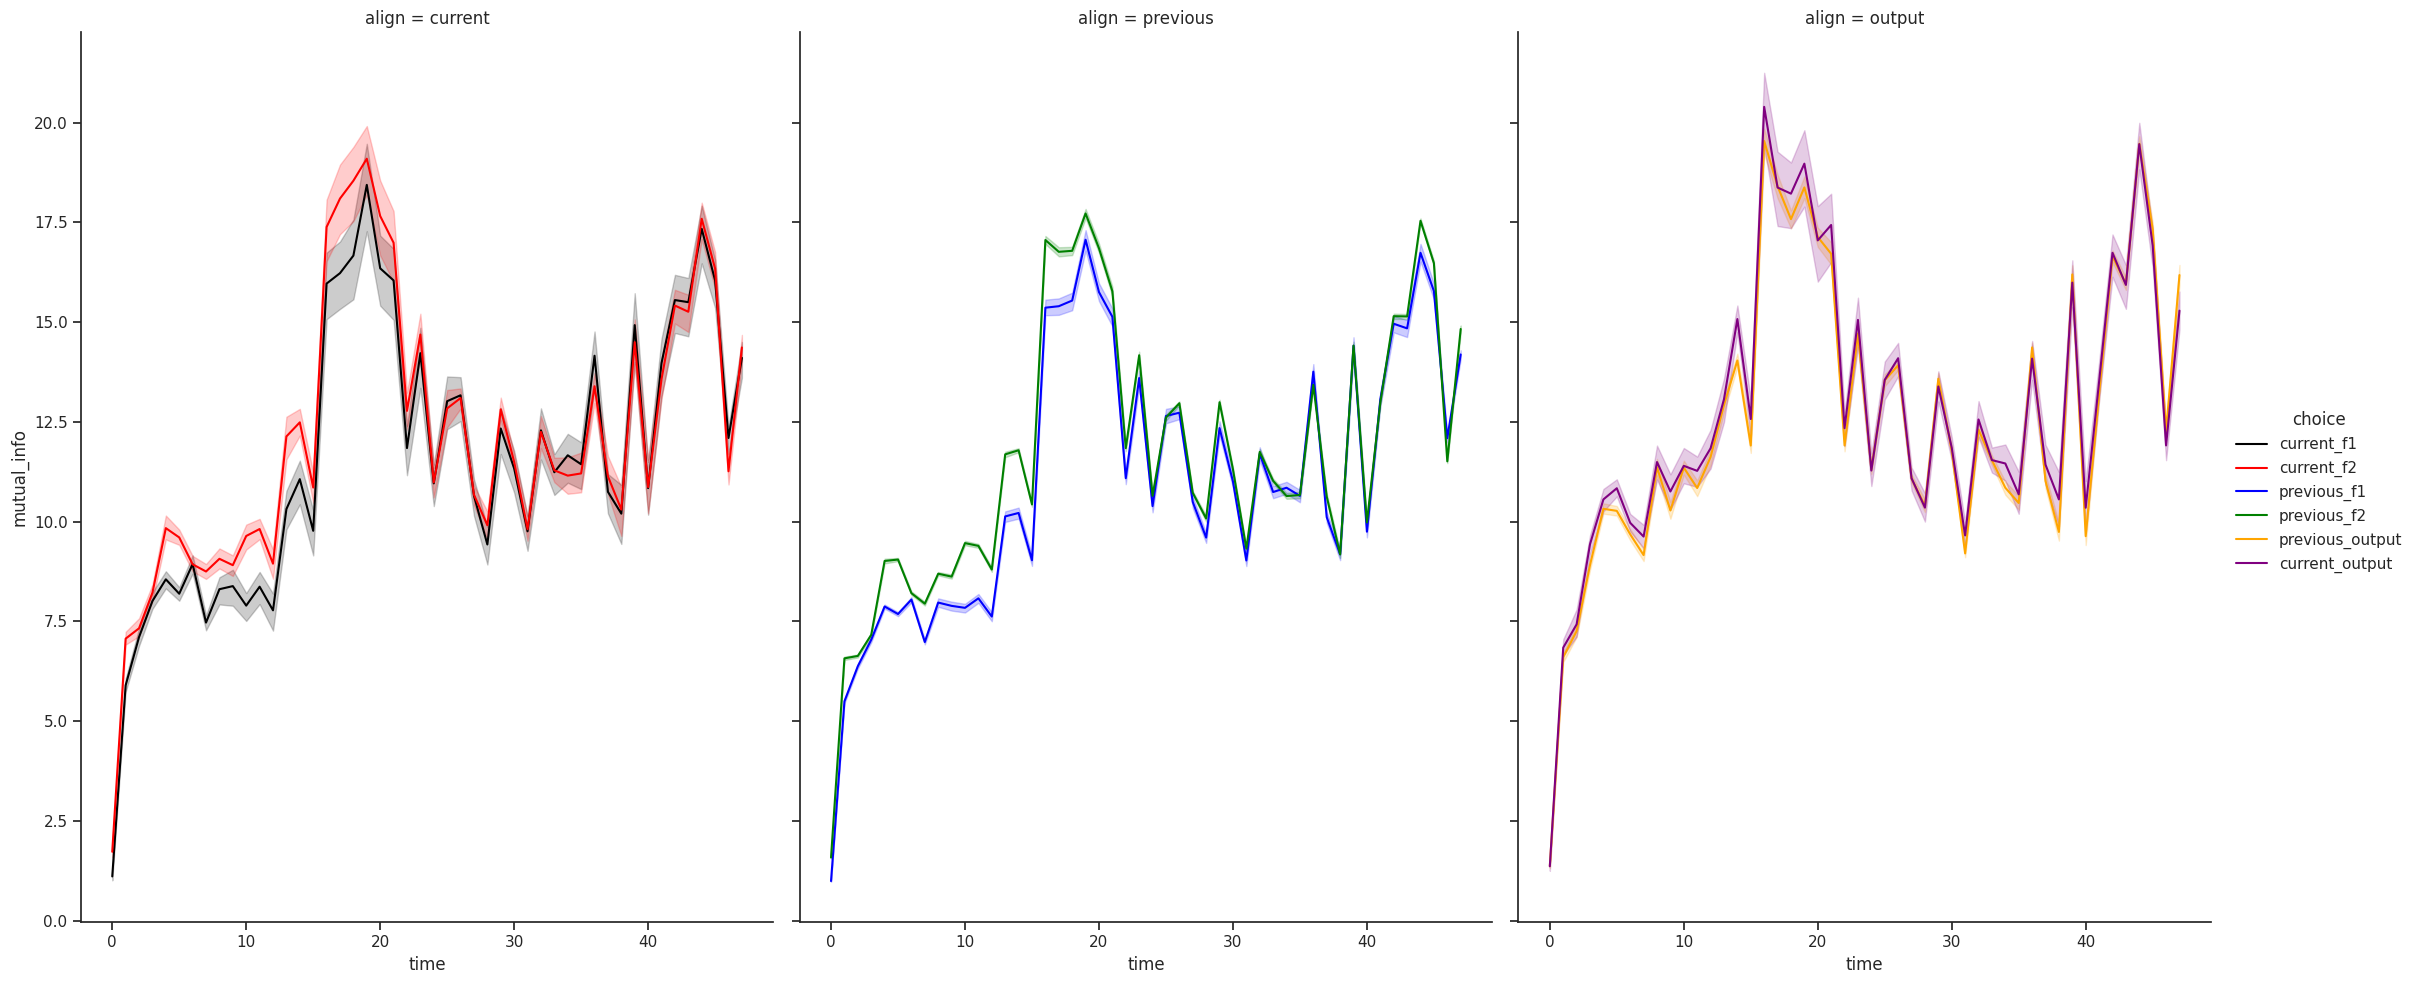

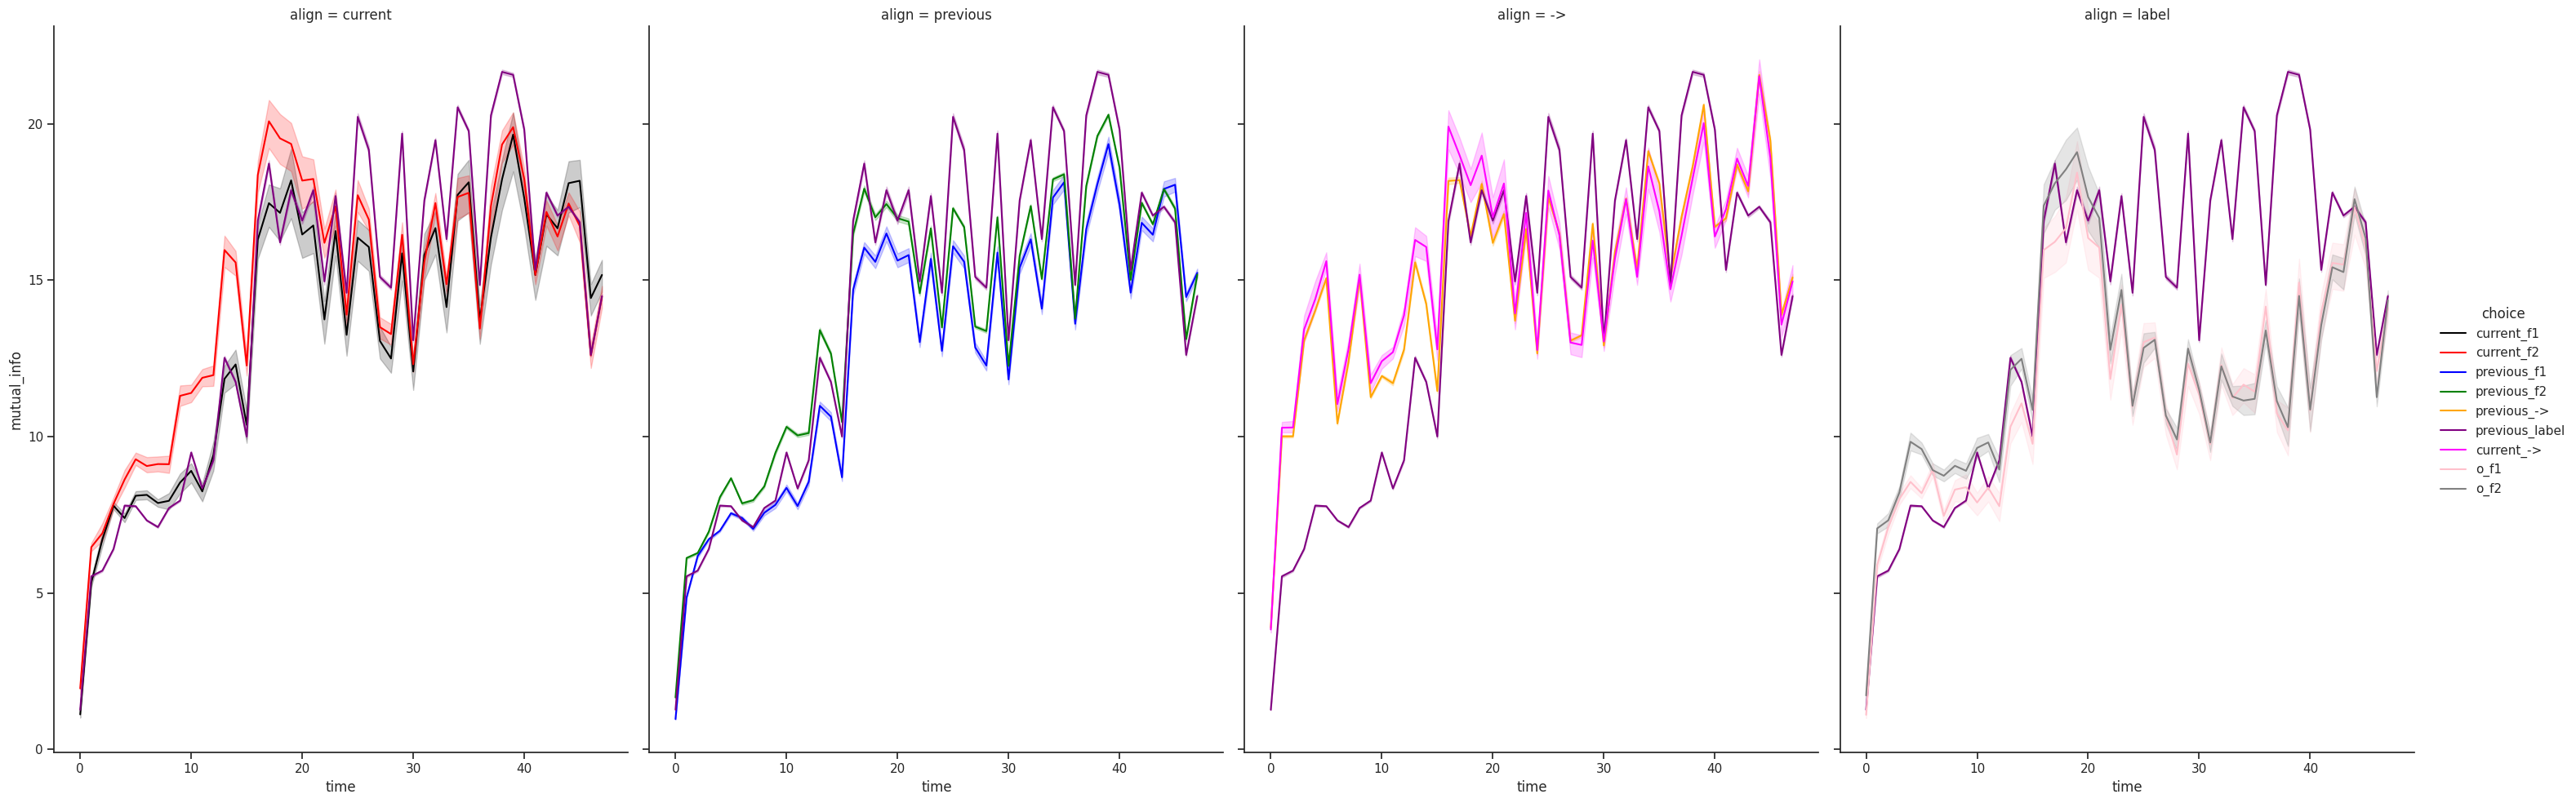

In [145]:
visualizer(data_o, finder='output')
visualizer(data_a, finder='->')

Note
- prev output is comparable to current output


In [101]:
# STACK -> MEAN
def _keys_dict(keys, f1s, f2s, outputs, loaded_dict, target):

    postfix = target.split('_')[1]

    # Initialize keys_dict with empty lists
    keys_dict = {key: [] for key in ['current_f1', 'current_f2', 'previous_f1', 'previous_f2', 'previous_output']}
    
    f1all, f2all, output_ult = [], [], []

    # Collect relevant keys for f1, f2, and output
    for key in keys:
        if postfix in key:
            if key == target:
                break
            output_ult.append(key)
        elif any(f in key for f in f1s):
            f1all.append(key)
        elif any(f in key for f in f2s):
            f2all.append(key)

    # Update keys_dict with current and previous values
    keys_dict['current_f1'].append(f1all[-1] if f1all else None)
    keys_dict['current_f2'].append(f2all[-1] if f2all else None)
    keys_dict['previous_f1'].extend(f1all[:-1])
    keys_dict['previous_f2'].extend(f2all[:-1])
    keys_dict['previous_output'].extend(output_ult)

    # Populate the data using the dictionary
    for k, v in keys_dict.items():
        if v == []:
            keys_dict[k] = []
        else:
            keys_dict[k] = [loaded_dict[target][keys.index(d)] for d in v]

    keys_dict['current_output'] = [loaded_dict[target][-1]]

    # go thrugh each key and calculate the mean
    for k, v in keys_dict.items():
        if v:
            keys_dict[k] = sum(v) / len(v)
        else:
            keys_dict[k] = None

    return keys_dict

idx_c = 0
f1s = f1_ult[idx_c]
f2s = f2_ult[idx_c]
outputs = output_ult[idx_c]

finder = 'output'

# go through each layer
layer_info = []
for layer, loaded_dict in enumerate(loaded_list_of_dicts):
    keys = list(loaded_dict.keys())
    
    finder_list = []
    for k in keys:
        # find output index
        if any(f in k for f in outputs) and finder == 'output':
            key_idx = keys.index(k)
            sub_keys_list = keys[:key_idx+1]
            finder_list.append(_keys_dict(sub_keys_list, f1s, f2s, outputs, loaded_dict, k))
    
    layer_info.append(finder_list)

new_layer_info = []
for info_list in layer_info:
    new_info_dict = {}
    for info in info_list:
        for k, v in info.items():
            if k not in new_info_dict:
                new_info_dict[k] = []
            new_info_dict[k].append(v)
    new_layer_info.append(new_info_dict)

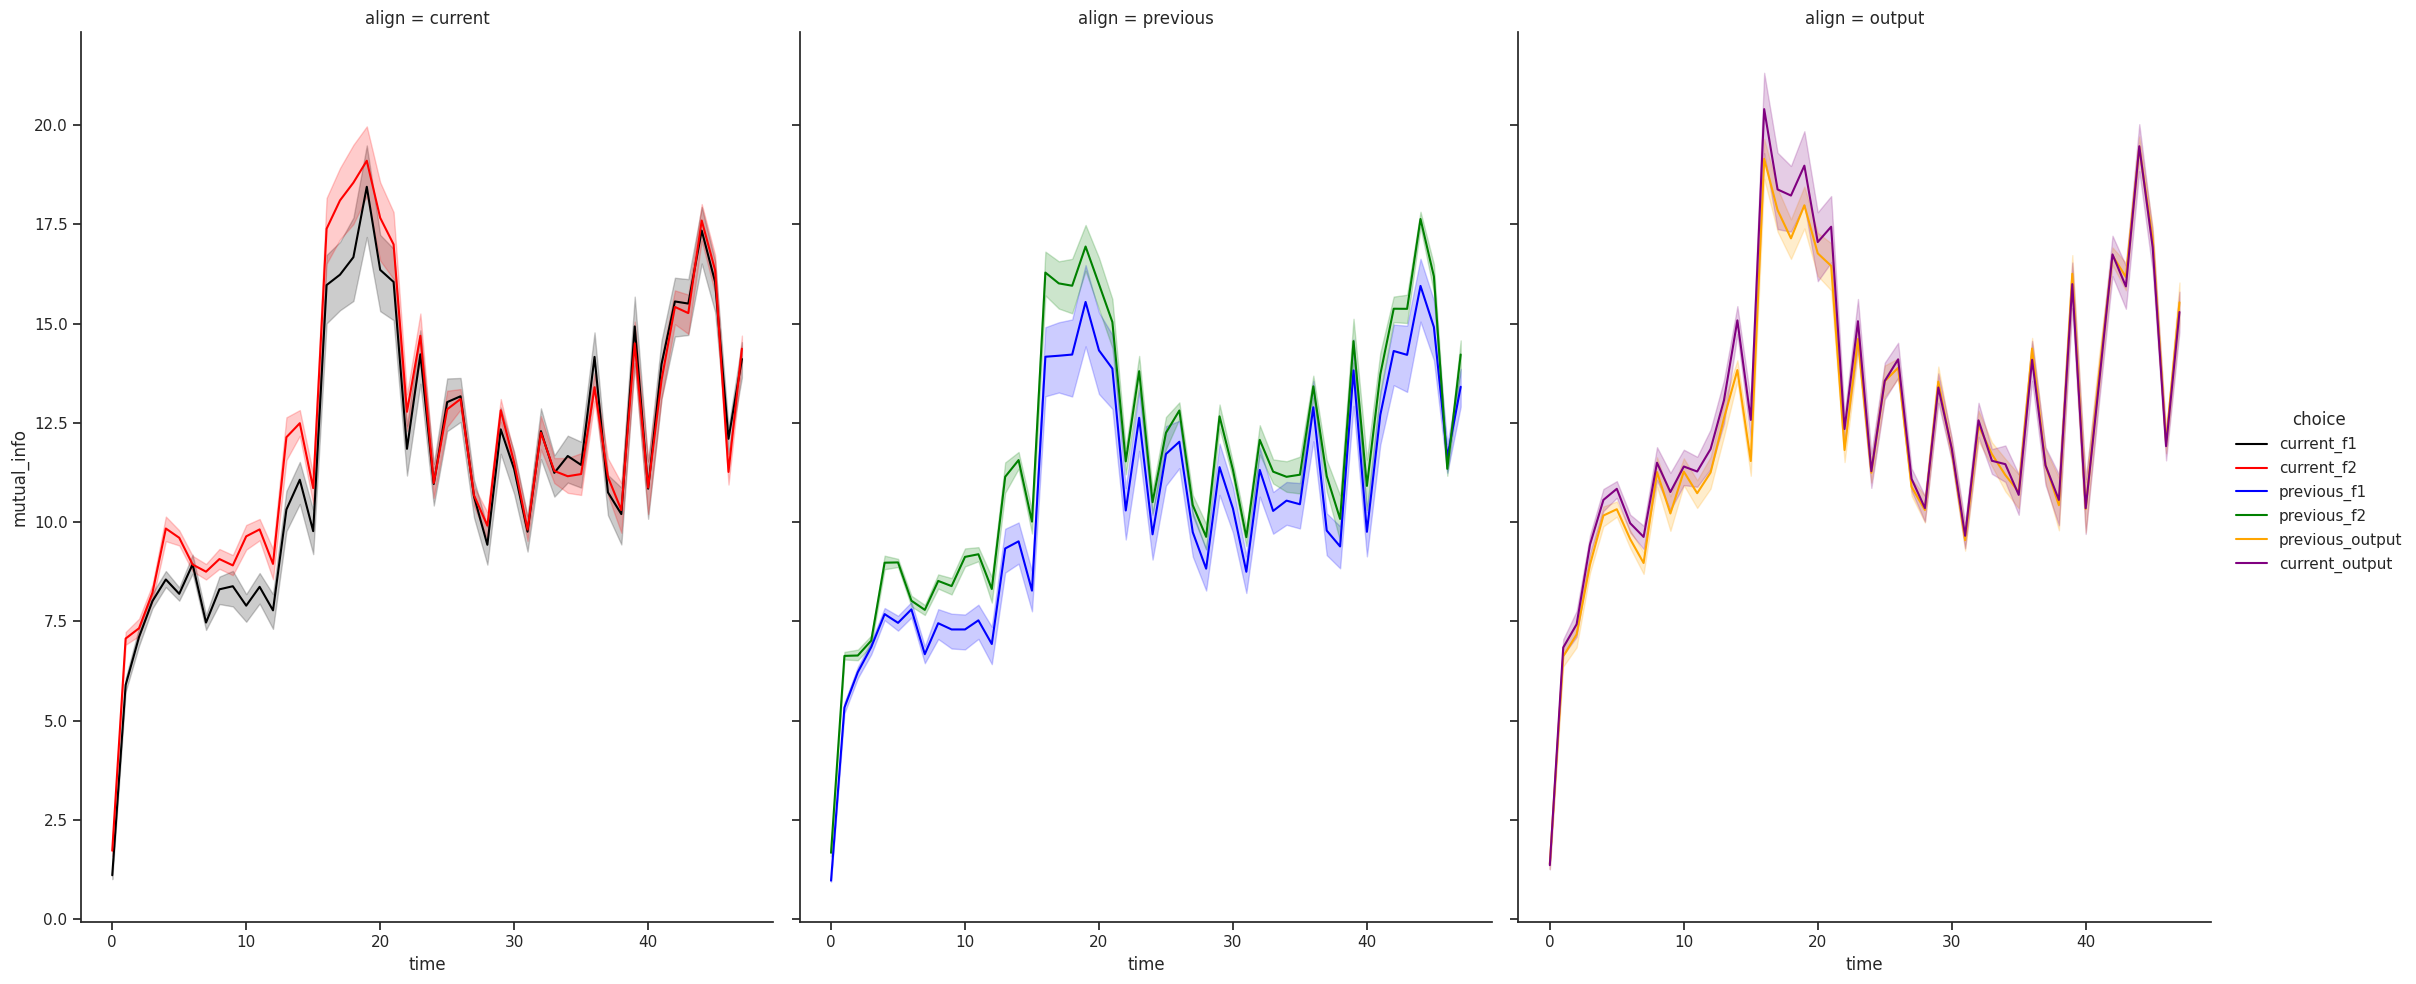

In [102]:
import pandas as pd

# Example list of dictionaries
data = new_layer_info

# Initialize a list to store the reformatted data
reformatted_data = []

# Iterate over the data
for idx, entry in enumerate(data):
    for key, value in entry.items():
        # Determine coherence based on the key
        if key == "current_f2":
            coherence = 0
            align = "current"
        if key == "previous_f2":
            coherence = 0
            align = "previous"
        if key == "previous_output":
            coherence = 1
            align = "output"
        if key == "current_output":
            coherence = 0
            align = "output"
        if key == "current_f1":
            coherence = 1
            align = "current"
        if key == "previous_f1":
            coherence = 1
            align = "previous"
        
        # Store the data in the desired format
        if isinstance(value, list):
            for v in value:
                reformatted_data.append({
                    "align": align,
                    "choice": key,
                    "time": idx,
                    "coherence": coherence,
                    "mutual_info": v
                })
        else:
            reformatted_data.append({
                "align": align,
                "choice": key,
                "time": idx,
                "coherence": coherence,
                "mutual_info": value
            })

# Convert the list of dicts to a DataFrame
df = pd.DataFrame(reformatted_data)

import seaborn as sns
sns.set_theme(style="ticks")

g = sns.relplot(
    data=df,
    x="time", y="mutual_info", col = "align",
    hue="choice",
    kind="line", palette=['black', 'red', 'blue', 'green', 'orange', 'purple'],
    height=10, aspect=.75, facet_kws=dict(sharex=False),
    legend="brief",
)


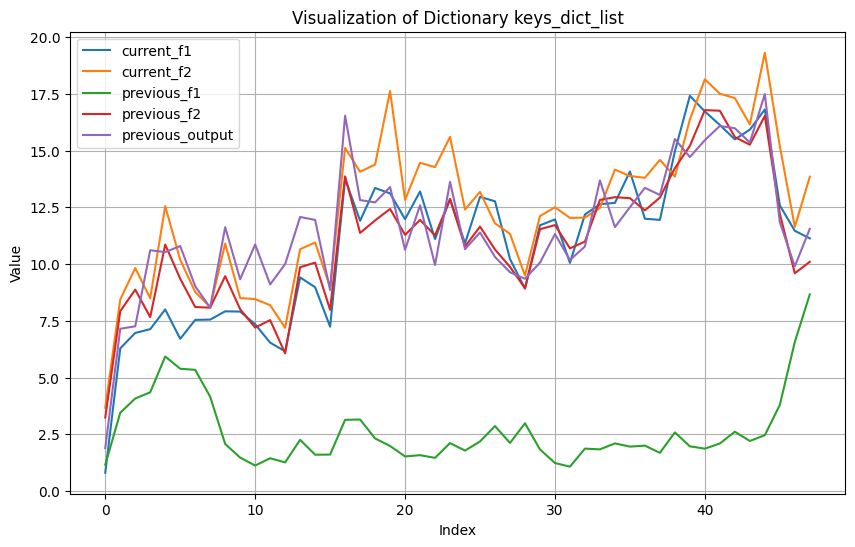

In [38]:
import matplotlib.pyplot as plt


# Convert list of dicts into a structure suitable for plotting
keys = keys_dict_list[0].keys()
values = {key: [] for key in keys}

# Extract values from dictionaries and organize them into lists
for idx, entry in enumerate(keys_dict_list):
    for key, value in entry.items():
        if isinstance(value, list):
            values[key].append(value[0])  # Unwrap list
        else:
            values[key].append(value)

# Plot the keys_dict_list
plt.figure(figsize=(10, 6))
for key, value in values.items():
    plt.plot(range(len(keys_dict_list)), value, label=key)

# Adding labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Visualization of Dictionary keys_dict_list")
plt.legend(loc="best")

# Show the plot
plt.grid(True)
plt.show()
